# **Recurrent Neural Networks, Gated Recurrent Unit, and Long Short-Term Memory**



In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
d = '/content/drive/MyDrive/project3_BehradBinaei_810101392/project3/'

NOTE 1: In Part I , you must
- explain all the codes line by line.
- improve the r2_score(preds, y_test) of the model.

#**Part I**
**In this part, we will be using the example data from the Max Planck Institute for Biogeochemistry. The dataset is called the Jena Climate dataset. It contains measurements like temperature, humidity, and more, recorded every 10 minutes. You have a dataset with measures on weather data, and we try to predict the temperature 12 hours (72-time steps of 10 minutes) into the future.We will use only the temperature data and not the other variables. This may make the task slightly harder to accomplish. Note that it is possible to add other explanatory variables into an RNN. For forecasting tomorrow’s temperature, you may want to use not only today’s temperature but also today’s wind direction, wind speed, and humidity, for example. In this case, you could add a third dimension to the input data.**

### **1.Import libraries**

In [1]:
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import os



### **2.Import our data.**

In [ ]:
csv_path = d+"jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [ ]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


### **3. The next step is to delete all columns other than the temperature, as we are building a univariate model. Keeping only the temperature data.**

In [ ]:
df = df[['T (degC)']]

### **4. We apply the min-max scaler.**

In [ ]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

In [ ]:
df.describe()

,T
count,420551.000000
mean,0.538400
std,0.139714
min,0.000000
25%,0.437386
50%,0.537900
75%,0.638248
max,1.000000


### **5. We prepare our data and convert the list of lists to numpy array.We need to split the data into a shape in which we have sequences of past data and sequences of future data. We want to predict 72 steps into the future, and we’ll use 3*72 steps into the past. This is an arbitrary choice. You can try out using more or less past data.**

In [ ]:
ylist = list(df['T'])

n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1

X_new = np.array(X_new)
y_new = np.array(y_new)

### **6.We do train test split.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.10, random_state=42)

In [ ]:
X_train.shape

(378236, 216)

### **7.It takes a long time to run this model. The batch size of 2000 is provided for demonstration purposes. But you need to put a much smaller batch size. Note that The SimpleRNN layer needs an input format that is 3D, and the shape has to correspond to (n_samples, n_timesteps, n_features). This can be obtained using reshape.**

In [ ]:
batch_size = 2000

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )

X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

### **8.We parameterize a small network with SimpleRNN.**
- Line 1: -------
- Line 2: -------
- Line 3:-------

In [ ]:
   !pip install keras-tuner --upgrade
   import tensorflow as tf
   from tensorflow.keras.models import Sequential
   from tensorflow.keras.layers import SimpleRNN, Dense
   from kerastuner.tuners import RandomSearch
   import numpy as np

   def build_model(hp):
       model = Sequential()
       model.add(SimpleRNN(
           units=hp.Int('units1', min_value=4, max_value=64, step=4),
           activation='tanh',
           input_shape=(n_timesteps, n_features),
           return_sequences=True
       ))
       model.add(SimpleRNN(
           units=hp.Int('units2', min_value=4, max_value=64, step=4),
           activation='tanh',
           return_sequences=True
       ))
       model.add(SimpleRNN(
           units=hp.Int('units3', min_value=4, max_value=64, step=4),
           activation='tanh'
       ))
       model.add(Dense(y_train.shape[1]))

       model.compile(
           optimizer=tf.keras.optimizers.Adam(
               hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
           loss='mean_absolute_error',
           metrics=['mean_absolute_error'],
       )
       return model

   tuner = RandomSearch(
       build_model,
       objective='val_mean_absolute_error',
       max_trials=8,
       executions_per_trial=1,
       directory='my_dir',
       project_name='hyperparam_tuning'
   )

   tuner.search_space_summary()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/129.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


<ipython-input-14-95f95abdf156>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 64, 'step': 4, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
   tuner.search(X_train_rs, y_train,
                epochs=8,
                validation_split=0.2,
                batch_size=batch_size)

   best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

   print(f"""
   The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('units1')},
   in the second layer is {best_hps.get('units2')}, and in the third layer is {best_hps.get('units3')}.
   The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
   """)

Trial 8 Complete [00h 11m 25s]
val_mean_absolute_error: 0.04234916716814041

Best val_mean_absolute_error So Far: 0.031335245817899704
Total elapsed time: 01h 27m 55s

The hyperparameter search is complete. The optimal number of units in the first layer is 64,
in the second layer is 44, and in the third layer is 24.
The optimal learning rate for the optimizer is 0.0008887474360333787.



Epoch 1/10
152/152 [==============================] - 81s 505ms/step - loss: 0.1328 - mean_absolute_error: 0.1328 - val_loss: 0.0484 - val_mean_absolute_error: 0.0484
Epoch 2/10
152/152 [==============================] - 79s 522ms/step - loss: 0.0465 - mean_absolute_error: 0.0465 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 3/10
152/152 [==============================] - 77s 504ms/step - loss: 0.0449 - mean_absolute_error: 0.0449 - val_loss: 0.0448 - val_mean_absolute_error: 0.0448
Epoch 4/10
152/152 [==============================] - 79s 519ms/step - loss: 0.0435 - mean_absolute_error: 0.0435 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373
Epoch 5/10
152/152 [==============================] - 78s 511ms/step - loss: 0.0450 - mean_absolute_error: 0.0450 - val_loss: 0.0421 - val_mean_absolute_error: 0.0421
Epoch 6/10
152/152 [==============================] - 82s 537ms/step - loss: 0.0423 - mean_absolute_error: 0.0423 - val_loss: 0.0420 - val_mean_absolute_error: 0.042

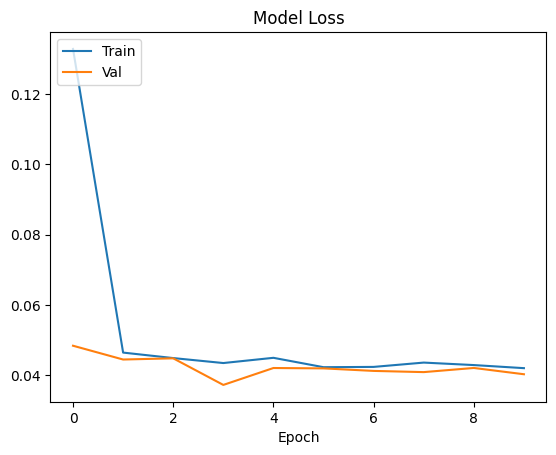

In [ ]:
   model = tuner.hypermodel.build(best_hps)
   history = model.fit(X_train_rs, y_train,
                       validation_split=0.2,
                       epochs=10,
                       batch_size=batch_size)

   preds = model.predict(X_test_rs)

   plt.plot(history.history['loss'])
   plt.plot(history.history['val_loss'])
   plt.title('Model Loss')
   plt.xlabel('Epoch')
   plt.legend(['Train', 'Val'], loc='upper left')
   plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.7776901329283811


### **9.A simple architecture with 1 Gated Recurrent Unit (GRU) layer.**

 #### hyperparameter tuning

In [5]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [8]:
import kerastuner as kt
from tensorflow.keras.layers import GRU

def build_simple_GRU(hyperparams):
    model = Sequential([
        GRU(hyperparams.Int('units', min_value=8, max_value=32, step = 4),
            activation='tanh',
            input_shape=(n_timesteps, n_features)),
        Dense(y_train.shape[1]),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hyperparams.Float('learning rate',min_value = 1e-4, max_value = 1e-2,sampling = 'LOG')),loss='mean_absolute_error',metrics=['mean_absolute_error'],
        )
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_simple_GRU,
    objective='val_mean_absolute_error',
    max_trials=6,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name = 'GRU'
)

tuner.search(X_train_rs, y_train, validation_split=0.2, epochs=5, batch_size=2000)

optimal_hp = tuner.get_best_hyperparameters()[0]

Trial 6 Complete [00h 00m 28s]
val_mean_absolute_error: 0.04503948241472244

Best val_mean_absolute_error So Far: 0.04503948241472244
Total elapsed time: 00h 02m 29s


These parameters are the optimal parameters

In [ ]:
print('Optimal Hyperparameters:')
for param in optimal_hp.values.keys():
    print(f'{param}: {optimal_hp.get(param)}')

Optimal Hyperparameters:
units: 28
learning rate: 0.0013027027591105272


#### Creating model with the best found parameters

In [ ]:
learning_rate = optimal_hp.get('learning rate')
units = optimal_hp.get('units')

final_model = Sequential([
        GRU(units, activation='tanh', input_shape=(n_timesteps, n_features)),
        Dense(y_train.shape[1]),
    ])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'],
)

#### Training the model

Epoch 1/20
2364/2364 [==============================] - 26s 10ms/step - loss: 0.0530 - mean_absolute_error: 0.0530 - val_loss: 0.0442 - val_mean_absolute_error: 0.0442
Epoch 2/20
2364/2364 [==============================] - 23s 10ms/step - loss: 0.0350 - mean_absolute_error: 0.0350 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 3/20
2364/2364 [==============================] - 24s 10ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 4/20
2364/2364 [==============================] - 26s 11ms/step - loss: 0.0274 - mean_absolute_error: 0.0274 - val_loss: 0.0273 - val_mean_absolute_error: 0.0273
Epoch 5/20
2364/2364 [==============================] - 23s 10ms/step - loss: 0.0271 - mean_absolute_error: 0.0271 - val_loss: 0.0269 - val_mean_absolute_error: 0.0269
Epoch 6/20
2364/2364 [==============================] - 24s 10ms/step - loss: 0.0268 - mean_absolute_error: 0.0268 - val_loss: 0.0267 - val_mean_absolute_error:

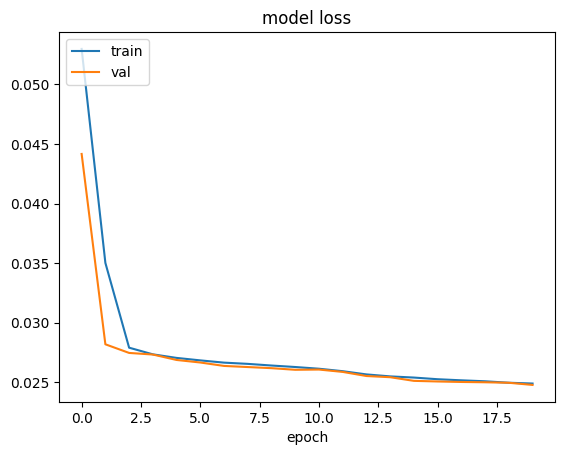

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

smod_history = final_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=20,
          batch_size=batch_size,
          shuffle = True,
          callbacks=[early_stopping]
)

preds = final_model.predict(X_test_rs)

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.9322497870577595


Hyperparameter Tuning improves $r^2$ score around 2%

####**10.This is a  more complex network with three layers of Gated Recurrent Unit (GRU).**

#### Hyperparameter Tuning

In [9]:
def build_complex_GRU(hyperparams):
    model = Sequential([
        GRU(hyperparams.Int('units', min_value=8, max_value=28, step = 8),activation='tanh',input_shape=(n_timesteps, n_features),return_sequences=True),
        Dropout(rate=hyperparams.Float('dropout', min_value=0.2,max_value=0.4, step=0.2)),
        GRU(hyperparams.Int('units', min_value=8, max_value=28, step = 8),activation='tanh', return_sequences=True),
        Dropout(rate=hyperparams.Float('dropout', min_value=0.2,max_value=0.4, step=0.2)),
        GRU(hyperparams.Int('units_second', min_value=8, max_value=16, step = 4),activation='tanh'),
        Dense(y_train.shape[1]),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hyperparams.Float('learning rate',min_value = 1e-4, max_value = 1e-3,sampling = 'LOG')),loss='mean_absolute_error',
        metrics=['mean_absolute_error'],)
    return model

In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout

tuner = kt.RandomSearch(
    build_complex_GRU,
    objective='val_mean_absolute_error',
    max_trials=6,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name = 'GRU_complex'
)

tuner.search(X_train_rs, y_train, validation_split=0.2, epochs=5,
             batch_size=2000)

optimal_hp = tuner.get_best_hyperparameters()[0]

Trial 6 Complete [00h 00m 52s]
val_mean_absolute_error: 0.04891236871480942

Best val_mean_absolute_error So Far: 0.0444093681871891
Total elapsed time: 00h 08m 08s


#### Best Hyperparametr

In [ ]:
print('Optimal Hyperparameters obtained after running 6 trials:')
for param in optimal_hp.values.keys():
    print(f'{param}: {optimal_hp.get(param)}')

Optimal Hyperparameters obtained after running 6 trials:
units: 16
dropout: 0.4
units_second: 8
learning rate: 0.000781544849838581


#### Creatinng model with the best found hyperparameter

In [ ]:
learning_rate = optimal_hp.get('learning rate')
units = optimal_hp.get('units')
units_second = optimal_hp.get('units_second')
dropout = optimal_hp.get('dropout')

final_model = Sequential([
    GRU(units, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    Dropout(dropout),
    GRU(units, activation='tanh', return_sequences=True),
    Dropout(dropout),
    GRU(units_second, activation='tanh'),
  Dense(y_train.shape[1]),
])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'],
)

#### Training model with the best found hyperparameter

Epoch 1/20
2364/2364 [==============================] - 70s 28ms/step - loss: 0.0642 - mean_absolute_error: 0.0642 - val_loss: 0.0420 - val_mean_absolute_error: 0.0420
Epoch 2/20
2364/2364 [==============================] - 59s 25ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.0304 - val_mean_absolute_error: 0.0304
Epoch 3/20
2364/2364 [==============================] - 64s 27ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 4/20
2364/2364 [==============================] - 59s 25ms/step - loss: 0.0289 - mean_absolute_error: 0.0289 - val_loss: 0.0274 - val_mean_absolute_error: 0.0274
Epoch 5/20
2364/2364 [==============================] - 62s 26ms/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.0271 - val_mean_absolute_error: 0.0271
Epoch 6/20
2364/2364 [==============================] - 62s 26ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - val_loss: 0.0268 - val_mean_absolute_error:

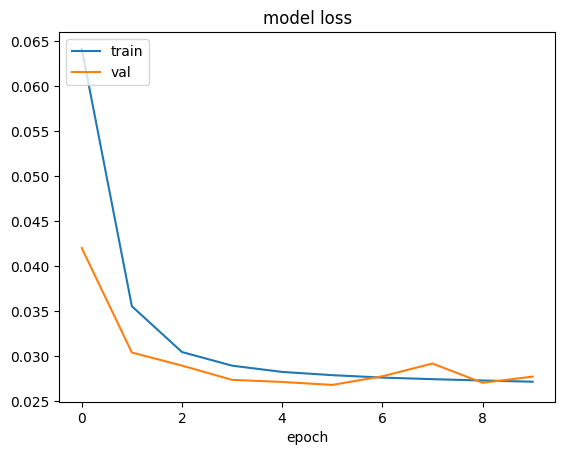

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

smod_history = final_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=20,
          batch_size=batch_size,
          shuffle = True,
          callbacks=[early_stopping]
)

preds = final_model.predict(X_test_rs)

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.9222735727011396


The $r^2$ score has increased 35%

### **Part 2:**

####**1. Import libraries.**

In [10]:
import pandas
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

#### **2. We normalize the dataset and do train and test split.**

What we have done:
- Sacling our fetures
- Splitting the train and test data (67%)

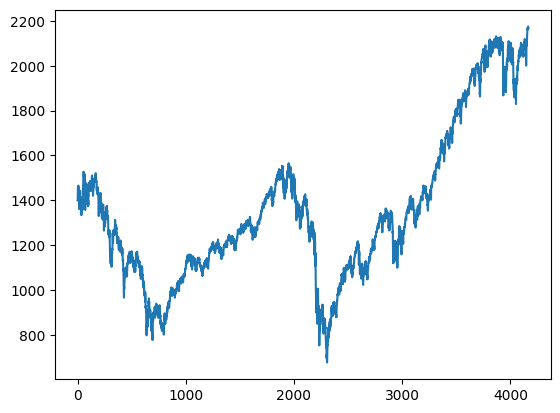

2791 1376


In [15]:
dataset = pandas.read_csv(d+ r'sp500.csv', usecols=[0], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
print(dataset)

[[0.48240909]
 [0.48420417]
 [0.48509838]
 ...
 [0.99562893]
 [0.99609603]
 [0.99436106]]


#### **3. We convert an array of values into a timeseries data.**

Now for turning our data into sequential data, the following function is designed which takes the dataset and the look back attribute (our window size), and then starts iterating over the dataset. For each data, it is first stored in the Y dataset in order to be predicted by the previous timesteps and then in the next ieration, it is stored in the X dataset in order to be used to predict the next timesteps. In each iteration, the value of our indicator index is increamenting one unit unitll it reaches the end of the dataset. Also, only the first column of the dataset is used as the data we're going to work with, thus, we'll only have one feature.

The look back feature basically is our window size, which determines the number of past observations that the model will consider to make a prediction. For instance, if look_back is set to 10, the model will use the last 10 time steps to predict the next value.

In [16]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#### About lookback parameter

Setting look back parameter to one means that each new prediction is done based on only the previous data sample. By increasing the look back (window size),we make the model more complex and more capable of capturing more information from the past for each prediction.

In the following code, we'll test the training results for three for different look back and we'll see that the best resulting value is corresponding to 1 look back.

In [17]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
trainX.shape

(2789, 1)

#### **4. We reshape input to be [samples, time steps, features].**

As we did for the previous models, we have to reshape the dataset so it becomes the desired 3D form in order to be fed into the LSTM model.

In [19]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### **5.We create and fit the LSTM network using hyperparameter tuning.**

In [20]:
def build_model(hp):
    # Extract unit hyperparameter
    units = hp.Int('units', min_value=2, max_value=10, step=2)

    # Build the new model
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1)))
    model.add(Dense(1))

    # Consider 3 possible value for learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

### HyperParameter Tuning

In [ ]:
look_backs = [1, 2, 3, 4]
best_hps = {}
losses = {}

for val in look_backs:
    look_back = val

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='my_dir',
        project_name='sp500_lstm' + f'_{look_back}'
    )

    tuner.search(trainX, trainY, epochs=15, batch_size=32, validation_split=0.2, verbose=2)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_hps[look_back] = best_hp
    best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    losses[look_back] = best_trial.metrics.get_best_value('val_loss')

Trial 10 Complete [00h 00m 15s]
val_loss: 0.0003100790490861982

Best val_loss So Far: 0.0001450149284210056
Total elapsed time: 00h 02m 51s


#### The Best Hyperparameter Found

In [ ]:
best_lb = 1

for key in best_hps[best_lb].values.keys():
        print(f'{key}: {best_hps[best_lb].get(key)}')

units: 8
learning_rate: 0.01


Now we create our model based on the obtained optimal hyperparameters and we build our dataset with value 1 for our look back.

Eventually, we train our new model on the data and also apply early stopping with 25 patience epochs. We also set the ```restore_best_weights``` to True so we'll have the best weights at the end.

#### Build the model with best hyperparameter

In [ ]:
best_params = best_hps[best_lb]
look_back = best_lb

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_params)

#### Create dataset based on the best look back

In [ ]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

#### Train the model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(trainX, trainY, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=2)

Epoch 1/150
70/70 - 3s - loss: 0.0095 - val_loss: 0.0031 - 3s/epoch - 49ms/step
Epoch 2/150
70/70 - 0s - loss: 6.9401e-04 - val_loss: 3.1388e-04 - 260ms/epoch - 4ms/step
Epoch 3/150
70/70 - 0s - loss: 1.3528e-04 - val_loss: 1.6269e-04 - 272ms/epoch - 4ms/step
Epoch 4/150
70/70 - 0s - loss: 1.2546e-04 - val_loss: 1.5997e-04 - 268ms/epoch - 4ms/step
Epoch 5/150
70/70 - 0s - loss: 1.2439e-04 - val_loss: 1.5553e-04 - 224ms/epoch - 3ms/step
Epoch 6/150
70/70 - 0s - loss: 1.2585e-04 - val_loss: 1.6713e-04 - 229ms/epoch - 3ms/step
Epoch 7/150
70/70 - 0s - loss: 1.2358e-04 - val_loss: 1.5417e-04 - 367ms/epoch - 5ms/step
Epoch 8/150
70/70 - 0s - loss: 1.2185e-04 - val_loss: 1.4496e-04 - 369ms/epoch - 5ms/step
Epoch 9/150
70/70 - 0s - loss: 1.2067e-04 - val_loss: 1.4394e-04 - 348ms/epoch - 5ms/step
Epoch 10/150
70/70 - 0s - loss: 1.1895e-04 - val_loss: 1.4099e-04 - 369ms/epoch - 5ms/step
Epoch 11/150
70/70 - 0s - loss: 1.1830e-04 - val_loss: 1.4310e-04 - 361ms/epoch - 5ms/step
Epoch 12/150
70/70

####**6.We rescale predicted values and compute the root mean squared error.**

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

43/43 [==============================] - 0s 2ms/step
Train Score: 14.99 RMSE
Test Score: 24.51 RMSE


Now thre RMSE tells us how much improve we have :)

#### **7. We shift train and test predictions for plotting and plot baseline and predictions.The part in orange is the training data, the part in blue is the test data, and the part in green is the predicted output.**

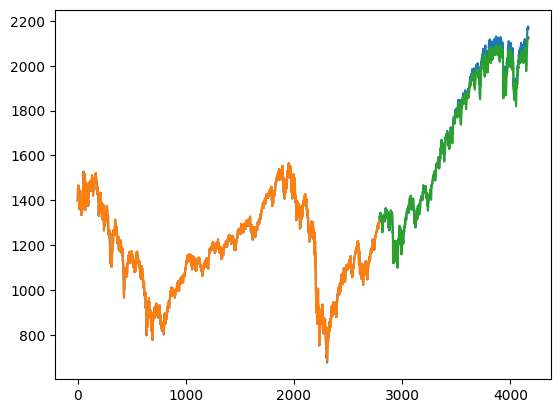

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()